In [7]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path('/home/quic/QUIC-Projects/ibmq_run_device_2')
OBJ_FUNC = r'$f_{\phi, \lambda}$'

DEVICE = 'montreal'
OFFSET = False

In [8]:
# plt.style.use(['science', 'nature', 'no-latex'])
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [9]:
class SineLSfitter(object):
    def __init__(self, theta, y):
        Y = np.matrix(y).T
        sinX = np.sin(theta)
        cosX = np.cos(theta)
        oneX = np.ones_like(theta)
        X = np.matrix(np.vstack([sinX, cosX, oneX])).T

        A, B, C = np.asarray(np.linalg.inv(X.T*X)*X.T*Y).flatten()
        self._A = A
        self._B = B
        self._C = C
        self.amp = np.sqrt(A**2+B**2)
        self.bias = C

    def __call__(self, x):
        return self._A*np.sin(x)+self._B*np.cos(x)+self._C

In [ ]:
%matplotlib inline

from qiskit.visualization.bloch import Bloch


def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

def map_bloch_sphere(data_dict):
    X=data_dict['X']
    y=data_dict['y']
    Xt=data_dict['Xt']
    yt=data_dict['yt']
    ax = plt.axes(projection='3d')
    B = Bloch(axes=ax)
    vecs = np.array(list(map(s2c, X)))
    for v in vecs[y==1]:
        B.add_annotation(v, text='A', color='r')
    for v in vecs[y==0]:
        B.add_annotation(v, text='B', color='b')

    vecs = np.array(list(map(s2c, Xt)))
    for v in vecs[yt==1]:
        B.add_annotation(v, text='*', color='r')
    for v in vecs[yt==0]:
        B.add_annotation(v, text='*', color='b')

    return B

In [20]:
import dill
from pathlib import Path
import json
from classifiers.quantum import Qasvm_Mapping_4x2
import matplotlib.lines as mlines

accuracy_cal = lambda yht, yt : sum(np.where(yht>0, 1, 0)==yt)/len(yt)

def load_exp_results(data_type):
    model_dir = Path(f'{DATA_DIR}/{data_type}/{DEVICE}/')

    with open(model_dir / 'exact_qasvm', 'rb') as f:
        exact_qasvm = dill.load(f)
    with open(model_dir / 'exact_storage', 'rb') as f:
        exact_storage = dill.load(f)
    exact_fvec = np.load(model_dir / 'exact_fvec.npy')

    with open(model_dir / 'real_qasvm', 'rb') as f:
        real_qasvm = dill.load(f)
    backend = real_qasvm.quantum_instance.backend
    with open(model_dir / 'real_storage', 'rb') as f:
        real_storage = dill.load(f)
    real_fvec = np.load(model_dir / 'real_fvec.npy')

    with open(model_dir / 'sim_qasvm', 'rb') as f:
        sim_qasvm = dill.load(f)
    with open(model_dir / 'sim_storage', 'rb') as f:
        sim_storage = dill.load(f)
    sim_fvec = np.load(model_dir / 'sim_fvec.npy')

    with open(model_dir / 'svm', 'rb') as f:
        svm = dill.load(f)
    svm_fvec = np.load(model_dir / 'svm_fvec.npy')

    with open(model_dir / 'uniform_qasvm', 'rb') as f:
        uniform_qasvm = dill.load(f)
    uniform_fvec = np.load(model_dir / 'uniform_fvec.npy')

    with open(model_dir / 'stc_qasvm', 'rb') as f:
        stc_qasvm = dill.load(f)
    with open(model_dir / 'stc_storage', 'rb') as f:
        stc_storage = dill.load(f)
    stc_fvec = np.load(model_dir / 'stc_fvec.npy')

    X = np.load(model_dir / 'X.npy')
    y = np.load(model_dir / 'y.npy')
    Xt = np.load(model_dir / 'Xt.npy')
    yt = np.load(model_dir / 'yt.npy')
    Xtt = np.load(model_dir / 'Xtt.npy')
    ytt = np.load(model_dir / 'ytt.npy')

    # Unknown bug fix
    if len(exact_fvec) != len(yt):
        exact_fvec = exact_fvec[4:]
    if len(sim_fvec) != len(yt):
        sim_fvec = sim_fvec[4:]
    if len(real_fvec) != len(yt):
        real_fvec = real_fvec[4:]
    if len(uniform_fvec) != len(yt):
        uniform_fvec = uniform_fvec[4:]
    if len(svm_fvec) != len(ytt):
        svm_fvec = svm_fvec[4:]
    if len(stc_fvec) != len(yt):
        stc_fvec = stc_fvec[4:]

    data_dict = dict(X=X, y=y, Xt=Xt, yt=yt, Xtt=Xtt, ytt=ytt)
    result_dict = dict(exact=exact_fvec, sim=sim_fvec, real=real_fvec, uniform=uniform_fvec, svm=svm_fvec, stc=stc_fvec)
    model_dict = dict(exact=exact_qasvm, sim=sim_qasvm, real=real_qasvm, uniform=uniform_qasvm, svm=svm, stc=stc_qasvm)
    storage_dict = dict(exact=exact_storage, sim=sim_storage, real=real_storage, stc=stc_storage)

    with open(model_dir / 'layout.json', 'r') as f:
        layout = Qasvm_Mapping_4x2(backend, **json.load(f))

    return data_dict, result_dict, model_dict, storage_dict, layout

def draw_result(data_dict, result_dict, offset_cal=False, option=False, model_dict=None):

    Xt=data_dict['Xt']
    yt=data_dict['yt']
    Xtt=data_dict['Xtt']

    svm_fvec = result_dict['svm']
    real_fvec = result_dict['real']
    sim_fvec = result_dict['sim']
    exact_fvec = result_dict['exact']
    stc_fvec = result_dict['stc']

    Stt = Xtt[:, 0]
    St = Xt[:, 0]
    if offset_cal:
        offset = real_fvec.mean()
    else:
        offset=0

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(Stt[:], svm_fvec, color='k')
    if not option:
        l0 = mlines.Line2D([], [], color='k', marker=None, linestyle='-', label='QKEM')
        l1 = mlines.Line2D([], [], color='k', marker='o', linestyle='none', label='QASVM. ({:.1%})'.format(accuracy_cal(exact_fvec, yt)))
        ax.scatter(St, exact_fvec, c=yt, cmap='bwr', marker='o')
        l4 = mlines.Line2D([], [], color='k', marker='^', linestyle='none', label='STC ({:.1%})'.format(accuracy_cal(stc_fvec, yt)))
        ax.scatter(St, stc_fvec, c=yt, cmap='bwr', marker='^')
        ax.legend(handles=[l0, l1, l4], loc='best')
    if option:
        l2 = mlines.Line2D([], [], color='k', marker='s', linestyle='none', label='noisy sim. ({:.1%})'.format(accuracy_cal(sim_fvec, yt)))
        ax.scatter(St, sim_fvec, c=yt, cmap='bwr', marker='s')
        l3 = mlines.Line2D([], [], color='k', marker='d', linestyle='none', label='ibmq_{:} ({:.1%})'.format(DEVICE, accuracy_cal(real_fvec-offset, yt)))
        ax.scatter(St, real_fvec-offset, c=yt, cmap='bwr', marker='d')
        fitter = SineLSfitter(St, real_fvec-offset)
        ax.plot(St, fitter(St), '--k')
        ax.legend(handles=[l2, l3], loc='best')
    data = model_dict['exact'].data
    label = model_dict['exact'].label
    for i, d in enumerate(data):
        data[i]=c2s(s2c(d))
    dataA = data[label==1]
    dataB = data[label==0]
    if sum(label)==2:
        dataA[:,0]=2*np.pi-dataA[:,0]
    else:
        dataB[:,0]=2*np.pi-dataB[:,0]
    ax.scatter(dataA[:, 0], np.zeros(len(dataA)), marker='$\mathrm{A}$', color='r', s=100)
    ax.scatter(dataB[:, 0], np.zeros(len(dataB)), marker='$\mathrm{B}$', color='b', s=100)
    ax.axhline(0, 0, 1, color='k', linestyle='--')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(OBJ_FUNC)
    ax.set_xticks([0, np.pi/2, np.pi, np.pi*3/2, np.pi*2])
    ax.set_xticklabels([0, r'$\pi/2$', r'$\pi$', r'$3/2\pi$', r'$2\pi$'])
    #print(fitter.amp)

    return fig

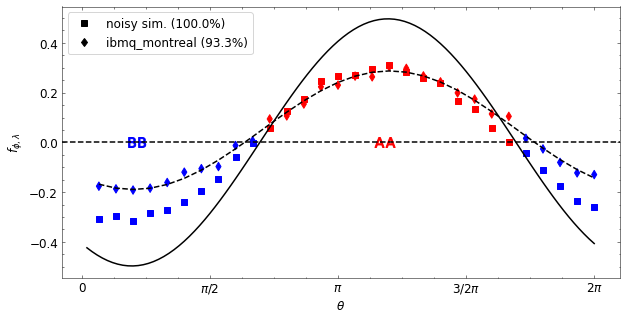

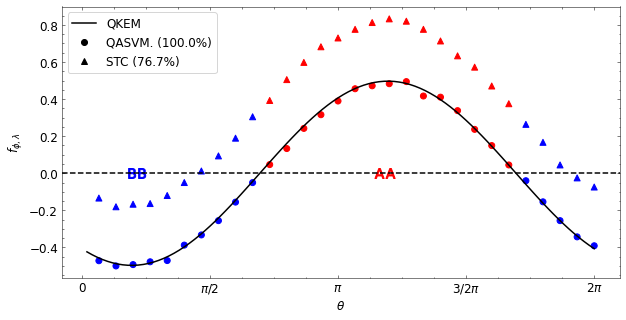

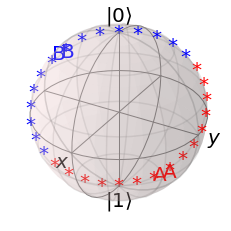

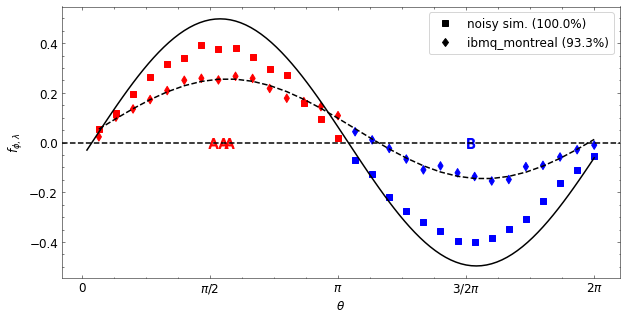

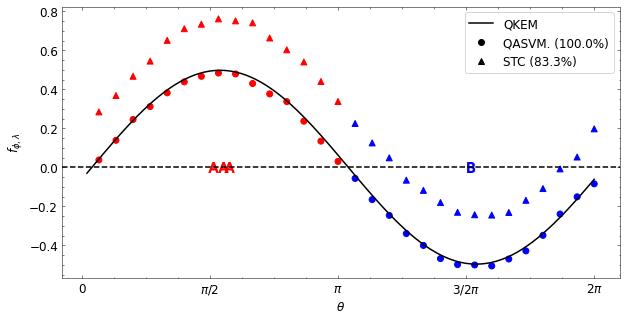

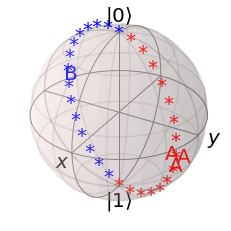

In [21]:
from classifiers.datasets.dataloader import Example_4xn

for dtype in ['balanced', 'unbalanced']:
    data_dict, result_dict, model_dict, storage_dict, layout = load_exp_results(dtype)
    draw_result(data_dict, result_dict, offset_cal=OFFSET, option=True, model_dict=model_dict).savefig(f'./figs/{DEVICE}/{dtype}_result.png')
    draw_result(data_dict, result_dict, offset_cal=OFFSET, option=False, model_dict=model_dict).savefig(f'./figs/noiseanal/{dtype}_result.png')
    plt.figure()
    B = map_bloch_sphere(data_dict)
    B.render()
    plt.savefig(f'./figs/{DEVICE}/{dtype}_bloch.png')
layout.plot('physical').savefig(f'./figs/{DEVICE}/layout.png')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [ ]:
"""# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.quantum.quantum_circuits import AnsatzCircuit9
from classifiers.optimizer import tSPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator

# for logging & visualization
import logging
from classifiers.callback import CostParamStorage
from tqdm.notebook import tqdm


MAXITER=2**10
LAST_AVG=16"""


In [ ]:
"""data_dict, result_dict, model_dict, storage_dict, layout = load_exp_results('balanced')
exact_qasvm = model_dict['exact']
exact_qasvm.parameters = 2*np.pi*np.random.rand(4)

exact_storage = CostParamStorage()
optimizer = tSPSA(maxiter=MAXITER, blocking=True, last_avg=LAST_AVG, callback=exact_storage)

for epoch in tqdm(range(1, MAXITER + 1)):
    optimizer.step(exact_qasvm.cost_fn, exact_qasvm.parameters)
    if exact_storage.num_accepted() > 2 * LAST_AVG and exact_storage.last_cost_avg(2 * LAST_AVG, ignore_rejected=True) < exact_storage.last_cost_avg(LAST_AVG, ignore_rejected=True):
        break

exact_qasvm.parameters = exact_storage.last_avg(LAST_AVG, ignore_rejected=True)
exact_fvec = exact_qasvm.f(data_dict['Xt'])
exact_qasvm.save(DATA_DIR/'balanced'/DEVICE/'exact_qasvm')
exact_storage.save(DATA_DIR/'balanced'/DEVICE/ 'exact_storage')
np.save(DATA_DIR/'balanced'/DEVICE/ 'exact_fvec.npy', exact_fvec)"""

In [ ]:
"""sim_qasvm = model_dict['sim']
sim_qasvm.parameters = 2*np.pi*np.random.rand(4)

sim_storage = CostParamStorage()
optimizer = tSPSA(maxiter=MAXITER, blocking=True, last_avg=LAST_AVG, callback=sim_storage)

for epoch in tqdm(range(1, MAXITER + 1)):
    optimizer.step(sim_qasvm.cost_fn, sim_qasvm.parameters)
    if sim_storage.num_accepted() > 2 * LAST_AVG and sim_storage.last_cost_avg(2 * LAST_AVG, ignore_rejected=True) < sim_storage.last_cost_avg(LAST_AVG, ignore_rejected=True):
        break

sim_qasvm.parameters = sim_storage.last_avg(LAST_AVG, ignore_rejected=True)
sim_fvec = sim_qasvm.f(data_dict['Xt'])
sim_qasvm.save(DATA_DIR/'balanced'/DEVICE/'sim_qasvm')
sim_storage.save(DATA_DIR/'balanced'/DEVICE/ 'sim_storage')
np.save(DATA_DIR/'balanced'/DEVICE/ 'sim_fvec.npy', sim_fvec)"""

In [ ]:
"""result_dict['exact'] = exact_fvec[4:] if len(exact_fvec) != len(data_dict['yt']) else exact_fvec
result_dict['sim'] = sim_fvec[4:] if len(sim_fvec) != len(data_dict['yt']) else sim_fvec
draw_result(data_dict, result_dict)"""

In [ ]:
%matplotlib inline
from classifiers.datasets.dataloader import Example_4xn
X, y = Example_4xn(balanced=True, logn=3)()
data_dict = load_exp_results('balanced')[0]
data_dict['X']=X
data_dict['y']=y
plt.figure()
map_bloch_sphere(data_dict).render()